# Exercises

## Acquire (`acquire.py`)

### Zillow
**For the following, iterate through the steps you would take to create functions: Write the code to do the following in a jupyter notebook, test it, convert to functions, then create the file to house those functions.**

**You will have a** 
`zillow.ipynb` 
**file and a helper file for each section in the pipeline.**

In [1]:
###############################################################################
### python imports                                                          ###
###############################################################################

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings("ignore")

# from math import sqrt
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [38]:
###############################################################################
### local imports                                                           ###
###############################################################################

import acquire as acq
import prepare as prep
import clusterfunctions as cf

from debug import local_settings, timeifdebug, timeargsifdebug, frame_splain
from dfo import DFO, set_dfo
from prepare import convert_to_dates, get_column_values_stats, retype_cols, nulls_by_row

In [3]:
local_settings.splain=True
local_settings.debug=True
splain = local_settings.splain
debug = local_settings.debug

In [4]:
from wrangle_zillow import get_zillow_data, prep_zillow_data, sqls

#### Acquire & Summarize

1. **Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.**

   - *Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for* 
`airconditioningtypeid`
*.*
   - Only include properties with a transaction in 2017, and include only the last transaction for each properity (so no duplicate property ID's), along with zestimate error and date of transaction.
   - Only include properties that include a latitude and longitude value.

In [5]:
dfo = set_dfo(get_zillow_data(sql=sqls['mvp']), splain=True)

2019-11-06 11:38:58 starting get_zillow_data
2019-11-06 11:38:58 starting sql_df
2019-11-06 11:38:58 starting get_db_url
2019-11-06 11:38:58 ending get_db_url ; time: 0:00:00.000776
2019-11-06 11:39:26 starting check_df
2019-11-06 11:39:26 starting frame_splain
DATAFRAME SHAPE:
(52161, 5) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52161 entries, 0 to 52160
Data columns (total 5 columns):
parcelid                        52161 non-null int64
bathroomcnt                     52161 non-null float64
bedroomcnt                      52161 non-null float64
calculatedfinishedsquarefeet    52161 non-null float64
logerror                        52161 non-null float64
dtypes: float64(4), int64(1)
memory usage: 2.0 MB
None 

DATAFRAME DESCRIPTION:
                                count          mean           std  \
parcelid                      52161.0  1.298865e+07  3.214306e+06   
bathroomcnt                   52161.0  2.305765e+00  1.017912e+00   
bedroomcnt              

2. **Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.).**

In [6]:
df = dfo.df

In [7]:
dfo.index_columns = 'parcelid'

In [8]:
dfo.y_column = 'logerror'

In [9]:
df = df.set_index(dfo.index_columns)

In [10]:
frame_splain(df, title='Zillow Data', splain=True)

2019-11-06 11:39:26 starting frame_splain
ZILLOW DATA SHAPE:
(52161, 4) 

ZILLOW DATA INFO:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52161 entries, 14297519 to 12826780
Data columns (total 4 columns):
bathroomcnt                     52161 non-null float64
bedroomcnt                      52161 non-null float64
calculatedfinishedsquarefeet    52161 non-null float64
logerror                        52161 non-null float64
dtypes: float64(4)
memory usage: 2.0 MB
None 

ZILLOW DATA DESCRIPTION:
                                count         mean          std        min  \
bathroomcnt                   52161.0     2.305765     1.017912    1.00000   
bedroomcnt                    52161.0     3.309676     0.933494    1.00000   
calculatedfinishedsquarefeet  52161.0  1923.742202  1003.723673  152.00000   
logerror                      52161.0     0.018157     0.176157   -4.65542   

                                      25%          50%          75%  \
bathroomcnt                      2.0

In [11]:
df = convert_to_dates(df, cols=['transactiondate'])

2019-11-06 11:39:26 starting convert_to_dates
2019-11-06 11:39:26 ending convert_to_dates ; time: 0:00:00.033613


In [12]:
df.head(15)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,logerror
parcelid,,,,
14297519,3.5,4.0,3100.0,0.025595
17052889,1.0,2.0,1465.0,0.055619
14186244,2.0,3.0,1243.0,0.005383
12177905,3.0,4.0,2376.0,-0.103410
12095076,3.0,4.0,2962.0,-0.001011
12069064,1.0,2.0,738.0,0.101723
12790562,3.0,4.0,3039.0,-0.040966
11104527,3.0,4.0,2540.0,0.005963
13944538,2.5,3.0,1340.0,0.045602


In [13]:
frame_splain(df, splain=True)

2019-11-06 11:39:26 starting frame_splain
DATAFRAME SHAPE:
(52161, 4) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52161 entries, 14297519 to 12826780
Data columns (total 4 columns):
bathroomcnt                     52161 non-null float64
bedroomcnt                      52161 non-null float64
calculatedfinishedsquarefeet    52161 non-null float64
logerror                        52161 non-null float64
dtypes: float64(4)
memory usage: 2.0 MB
None 

DATAFRAME DESCRIPTION:
                                count         mean          std        min  \
bathroomcnt                   52161.0     2.305765     1.017912    1.00000   
bedroomcnt                    52161.0     3.309676     0.933494    1.00000   
calculatedfinishedsquarefeet  52161.0  1923.742202  1003.723673  152.00000   
logerror                      52161.0     0.018157     0.176157   -4.65542   

                                      25%          50%          75%  \
bathroomcnt                      2.000000 

**Find string categoricals**

In [34]:
df_strings = get_column_values_stats(
    df, 
    get_cols=df.columns[df.dtypes=='object'],
    max_uniques=20000,
    limit_to_max=True
)
df_strings

2019-11-06 11:44:40 starting get_column_values_stats
2019-11-06 11:44:40 ending get_column_values_stats ; time: 0:00:00.142329


,dtype,num_rows_values,num_rows_missing,pct_rows_missing,num_uniques,unique_values
cols,,,,,,
bathroomcnt,float64,52161,0,0.0,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ..."
bedroomcnt,float64,52161,0,0.0,13,"[4.0, 2.0, 3.0, 6.0, 5.0, 1.0, 7.0, 8.0, 9.0, ..."
calculatedfinishedsquarefeet,float64,52161,0,0.0,4712,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0..."


In [31]:
df_strings.index

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet'], dtype='object', name='cols')

In [16]:
string_categoricals = [
    'airconditioningdesc', 
    'architecturalstyledesc', 
    'buildingclassdesc', 
    'county', 
    'state', 
    'heatingorsystemdesc', 
    'propertycountylandusecode', 
    'propertylandusedesc', 
    'propertyzoningdesc', 
    'storydesc', 
    'taxdelinquencyflag', 
    'typeconstructiondesc'
]

In [17]:
df = retype_cols(df, cols=string_categoricals, to_dtype='category')
df.info()

2019-11-06 11:39:27 starting retype_cols
2019-11-06 11:39:27 ending retype_cols ; time: 0:00:00.003441
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52161 entries, 14297519 to 12826780
Data columns (total 4 columns):
bathroomcnt                     52161 non-null float64
bedroomcnt                      52161 non-null float64
calculatedfinishedsquarefeet    52161 non-null float64
logerror                        52161 non-null float64
dtypes: float64(4)
memory usage: 2.0 MB


**Find Numeric Categoricals**

In [18]:
df_cat_check = prep.get_column_values_stats(
    df, 
    get_cols=df.columns[df.dtypes!='category'],
    max_uniques=750000,
    target_col=dfo.y_column,
    limit_to_max=True
)
df_cat_check

2019-11-06 11:39:27 starting get_column_values_stats
2019-11-06 11:39:27 ending get_column_values_stats ; time: 0:00:00.051824


,dtype,num_rows_values,num_rows_missing,pct_rows_missing,num_uniques,unique_values
cols,,,,,,
bathroomcnt,float64,52161,0,0.0,21,"[3.5, 1.0, 2.0, 3.0, 2.5, 4.5, 4.0, 5.0, 6.5, ..."
bedroomcnt,float64,52161,0,0.0,13,"[4.0, 2.0, 3.0, 6.0, 5.0, 1.0, 7.0, 8.0, 9.0, ..."
calculatedfinishedsquarefeet,float64,52161,0,0.0,4712,"[3100.0, 1465.0, 1243.0, 2376.0, 2962.0, 738.0..."
logerror,float64,52161,0,0.0,51903,"[0.025594901758400002, 0.0556190874015, 0.0053..."


In [19]:
df_cat_check.index

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'logerror'],
      dtype='object', name='cols')

In [20]:
numeric_categoricals = [
    'airconditioningtypeid', 
    'architecturalstyletypeid', 
    'buildingclasstypeid', 
    'buildingqualitytypeid',
    'decktypeid', 
    'fips', 
    'hashottuborspa',
    'heatingorsystemtypeid',
    'pooltypeid10', 
    'pooltypeid2', 
    'pooltypeid7', 
    'propertylandusetypeid',
    'regionidcounty', 
    'regionidcity',
    'regionidneighborhood',
    'regionidzip',
    'rawcensustractandblock',
    'censustractandblock',
    'storytypeid', 
    'threequarterbathnbr', 
    'numberofstories', 
    'fireplaceflag', 
    'assessmentyear', 
    'typeconstructiontypeid', 
    'transactions'
]

In [35]:
df = retype_cols(df, cols=numeric_categoricals, to_dtype='category')
df.info()

2019-11-06 11:44:51 starting retype_cols
2019-11-06 11:44:51 ending retype_cols ; time: 0:00:00.000254
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52161 entries, 14297519 to 12826780
Data columns (total 4 columns):
bathroomcnt                     52161 non-null float64
bedroomcnt                      52161 non-null float64
calculatedfinishedsquarefeet    52161 non-null float64
logerror                        52161 non-null float64
dtypes: float64(4)
memory usage: 2.0 MB


In [36]:
nulls_by_row(df)

2019-11-06 11:44:57 starting nulls_by_row
2019-11-06 11:44:57 ending nulls_by_row ; time: 0:00:00.030284


,num_cols_missing,pct_cols_missing,parcelid
0,0,0.0,52161


#### Prepare

1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.

2. Create a function that will drop rows or columns based on the percent of values that are missing: `handle_missing_values(df, prop_required_column, prop_required_row)`.

   - The input:
       - A dataframe
       - A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
       - A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).
   - The output:
       - The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.
   - hint:
       - Look up the dropna documentation.
       - You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.
       - Make use of inplace, i.e. inplace=True/False.

In [23]:
# def handle_missing_values(
#     df, 
#     prop_required_column, 
#     prop_required_row
#     ):
#     '''
#     handle_missing_values(
#     df, 
#     prop_required_column=.9, 
#     prop_required_row=.9
#     )
#     '''
    

3. Decide how to handle the remaining missing values:
   - Fill with constant value.
   - Impute with mean, median, mode.
   - Drop row/column

In [24]:
# df_sqft = df[['calculatedfinishedsquarefeet',
# 'finishedfloor1squarefeet',
# 'finishedsquarefeet6',
# 'finishedsquarefeet12',
# 'finishedsquarefeet13',
# 'finishedsquarefeet15',
# 'finishedsquarefeet50'
# ]]

#### `wrangle_zillow.py`

Functions of the work above needed to acquire and prepare a new sample of data.

In [25]:
# df_sqft[df_sqft.calculatedfinishedsquarefeet.isna() & (df_sqft.finishedsquarefeet50.isna()==False)]

In [26]:
# df_pool = df[['poolcnt','poolsizesum','pooltypeid2','pooltypeid7','pooltypeid10']]
# df_pool[(df_pool.poolcnt.isna()==False) | (df_pool.pooltypeid10.isna()==False)]

In [27]:
dfo.df = df
dfo.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52161 entries, 14297519 to 12826780
Data columns (total 4 columns):
bathroomcnt                     52161 non-null float64
bedroomcnt                      52161 non-null float64
calculatedfinishedsquarefeet    52161 non-null float64
logerror                        52161 non-null float64
dtypes: float64(4)
memory usage: 2.0 MB


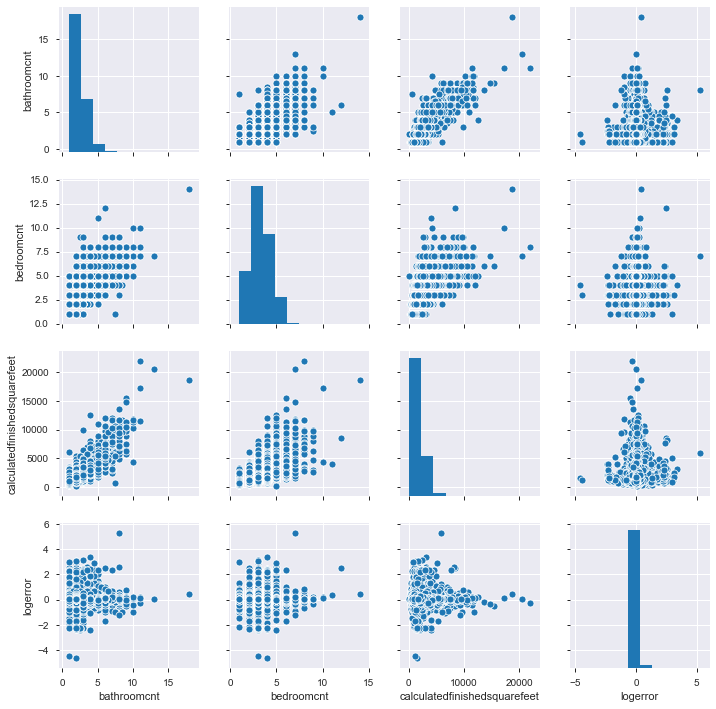

In [37]:
sns.pairplot(df)

In [42]:
dfo.X, dfo.y = prep.xy_df(dfo.df, dfo.y_column)

2019-11-06 12:01:00 starting xy_df
2019-11-06 12:01:00 starting frame_splain
2019-11-06 12:01:00 ending frame_splain ; time: 0:00:00.000173
2019-11-06 12:01:00 starting frame_splain
2019-11-06 12:01:00 ending frame_splain ; time: 0:00:00.000937
2019-11-06 12:01:00 ending xy_df ; time: 0:00:00.006129


In [44]:
X = dfo.X
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52161 entries, 14297519 to 12826780
Data columns (total 3 columns):
bathroomcnt                     52161 non-null float64
bedroomcnt                      52161 non-null float64
calculatedfinishedsquarefeet    52161 non-null float64
dtypes: float64(3)
memory usage: 4.1 MB


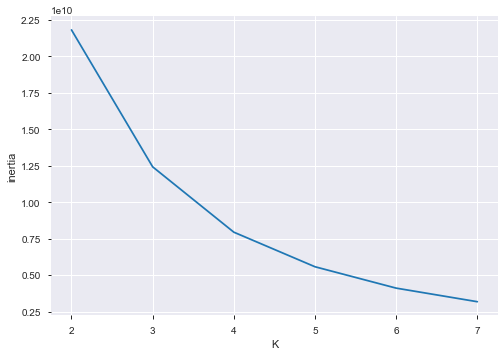

In [47]:
cf.compare_ks(X, min_k=2, max_k=7)

In [48]:
cf.set_kmeans_clusters(X, 5)
X.head(15)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,cluster
parcelid,,,,
14297519,3.5,4.0,3100.0,1
17052889,1.0,2.0,1465.0,0
14186244,2.0,3.0,1243.0,0
12177905,3.0,4.0,2376.0,1
12095076,3.0,4.0,2962.0,1
12069064,1.0,2.0,738.0,0
12790562,3.0,4.0,3039.0,1
11104527,3.0,4.0,2540.0,1
13944538,2.5,3.0,1340.0,0


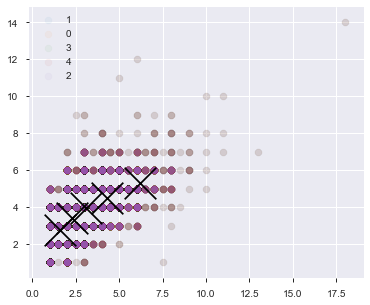

In [55]:
plt.figure(figsize=(6,5))
cf.plot_2d_clusters(X, x_col='bathroomcnt', y_col='bedroomcnt', c_col='cluster')
plt.show()

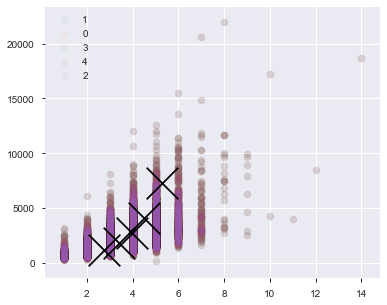

In [56]:
plt.figure(figsize=(6,5))
cf.plot_2d_clusters(X, x_col='bedroomcnt', y_col='calculatedfinishedsquarefeet', c_col='cluster')
plt.show()

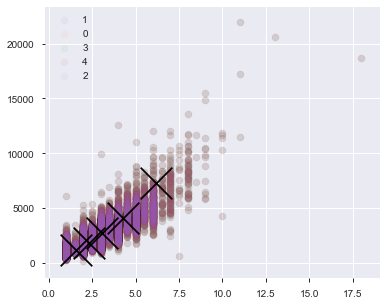

In [57]:
plt.figure(figsize=(6,5))
cf.plot_2d_clusters(X, x_col='bathroomcnt', y_col='calculatedfinishedsquarefeet', c_col='cluster')
plt.show()

In [91]:
def feature_pairing(df, c_col=None, **kwargs):
    
    cols = [col for col in df.columns if col != c_col]
    n = len(cols)
    grid = []
    for i in range(0, n-1):
        for j in range(i+1, n):
            line = [cols[i], cols[j]]
            grid.append(line)
    
    return_df = pd.DataFrame(grid, columns=['x_col', 'y_col'])
    if c_col:
        return_df['c_col'] = c_col
    return return_df

In [92]:
feature_pairing(X)

,x_col,y_col
0,bathroomcnt,bedroomcnt
1,bathroomcnt,calculatedfinishedsquarefeet
2,bathroomcnt,cluster
3,bedroomcnt,calculatedfinishedsquarefeet
4,bedroomcnt,cluster
5,calculatedfinishedsquarefeet,cluster


In [93]:
feature_pairing(X, c_col='cluster')

,x_col,y_col,c_col
0,bathroomcnt,bedroomcnt,cluster
1,bathroomcnt,calculatedfinishedsquarefeet,cluster
2,bedroomcnt,calculatedfinishedsquarefeet,cluster


In [ ]:
plt.figure(figsize=(6,5))

